# Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration --

# Load 100k rows for faster imports

In [3]:
N_ROWS_TO_LOAD = 100000 
CSV_FILE_PATH = "brewery_data_complete_extended.csv"

# Parameters to use in the dataset

In [4]:
THESIS_PARAMETERS = ['Gravity', 'Alcohol_Content', 'pH_Level', 'Moisture_Content', 'Temperature']
BRIX_COLUMN = 'Gravity' # Using Gravity as a proxy for Brix
ALCOHOL_COLUMN = 'Alcohol_Content'
PH_COLUMN = 'pH_Level'
MOISTURE_COLUMN = 'Moisture_Content' # This will be simulated
TEMP_COLUMN = 'Temperature'

In [ ]:
try:
    df = pd.read_csv(CSV_FILE_PATH, nrows=N_ROWS_TO_LOAD)
    print(f"Successfully loaded {len(df)} rows from '{CSV_FILE_PATH}'.")
    df_loaded_successfully = True

    # --- Simulate 'Moisture_Content' if not present
    if MOISTURE_COLUMN not in df.columns:
        print(f"'{MOISTURE_COLUMN}' not found in the dataset. Simulating it for demonstration.")
        # Simulate moisture content, e.g., typically high in liquids, decreases slightly with fermentation
        # This is a VERY ROUGH simulation. Actual data would be sensor-derived.
        np.random.seed(42) # for reproducibility
        df[MOISTURE_COLUMN] = np.random.uniform(low=85.0, high=95.0, size=len(df)) - (df[ALCOHOL_COLUMN] * 0.1 if ALCOHOL_COLUMN in df.columns else 0)
        df[MOISTURE_COLUMN] = df[MOISTURE_COLUMN].round(2)
        # Add some NaNs and potential outliers for preprocessing demonstration
        nan_indices = df.sample(frac=0.05, random_state=42).index # 5% NaNs
        df.loc[nan_indices, MOISTURE_COLUMN] = np.nan
        outlier_indices = df.sample(frac=0.01, random_state=1).index # 1% outliers
        df.loc[outlier_indices, MOISTURE_COLUMN] = np.random.uniform(low=60, high=70, size=len(outlier_indices))

    # Convert Gravity to Brix using the standard formula: Brix = (Gravity - 1) * 1000 / 4
    if BRIX_COLUMN in df.columns:
        print(f"Converting '{BRIX_COLUMN}' from Gravity to Brix scale...")
        df[BRIX_COLUMN] = pd.to_numeric(df[BRIX_COLUMN], errors='coerce')
        df[BRIX_COLUMN] = (28.14203*df[BRIX_COLUMN])+202.4427-230.5870/df[BRIX_COLUMN]
        df[BRIX_COLUMN] = df[BRIX_COLUMN].round(2)
        print(f"First 5 converted Brix values:\n{df[BRIX_COLUMN].head()}")

except FileNotFoundError:
    print(f"ERROR: File '{CSV_FILE_PATH}' not found.")
    print("Please ensure the CSV file is in the same directory or provide the correct path.")
    print("Creating a dummy DataFrame for demonstration purposes.")
    # Create a placeholder DataFrame if the actual file isn't found
    data = {
        'Batch_ID': range(100),
        'Brew_Date': pd.to_datetime(['2023-01-01 10:00:00'] * 100) + pd.to_timedelta(np.arange(100), 'H'),
        BRIX_COLUMN: np.random.uniform(1.030, 1.080, 100).round(6), # Proxy for Brix
        ALCOHOL_COLUMN: np.random.uniform(4.0, 7.0, 100).round(2),
        PH_COLUMN: np.random.uniform(4.0, 5.5, 100).round(2),
        MOISTURE_COLUMN: np.random.uniform(85.0, 95.0, 100).round(2), # Simulated
        TEMP_COLUMN: np.random.uniform(15.0, 25.0, 100).round(2),
        'Beer_Style': np.random.choice(['Ale', 'Lager', 'Stout'], 100),
        'Location': np.random.choice(['LocationA', 'LocationB'], 100)
    }
    # Introduce some common data issues for preprocessing demonstration
    for col in [BRIX_COLUMN, ALCOHOL_COLUMN, PH_COLUMN, MOISTURE_COLUMN, TEMP_COLUMN]:
        df_temp = pd.DataFrame(data)
        nan_indices = df_temp.sample(frac=0.05, random_state=42).index
        df_temp.loc[nan_indices, col] = np.nan
        # Add a string error to pH and Gravity (Brix) to mimic real-world issues
        if col == PH_COLUMN:
            str_err_idx = df_temp.sample(frac=0.02, random_state=10).index
            df_temp.loc[str_err_idx, col] = "5.2-5.3" # Example string error
        if col == BRIX_COLUMN:
            str_err_idx = df_temp.sample(frac=0.02, random_state=11).index
            df_temp.loc[str_err_idx, col] = "1.050-1.055" # Example string error
    df = pd.DataFrame(df_temp) # Use the DataFrame with introduced issues
    df_loaded_successfully = False
    print("\nDummy DataFrame head:")
    print(df.head())

# Ensure all target thesis parameters exist, even if just as placeholders after dummy creation
for param in [BRIX_COLUMN, ALCOHOL_COLUMN, PH_COLUMN, MOISTURE_COLUMN, TEMP_COLUMN]:
    if param not in df.columns:
        df[param] = np.nan # Add as empty if completely missing

if df_loaded_successfully or not df_loaded_successfully: # Proceed if df exists
    print("\nInitial DataFrame info:")
    df.info()
    print(f"\nFocus on need parameters: {THESIS_PARAMETERS}")

Successfully loaded 100000 rows from 'brewery_data_complete_extended.csv'.
'Moisture_Content' not found in the dataset. Simulating it for demonstration.
Converting 'Gravity' from Gravity to Brix scale...
First 5 converted Brix values:
0     9.88
1    14.95
2     9.37
3    13.11
4    13.57
Name: Gravity, dtype: float64

Initial DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Batch_ID                      100000 non-null  int64  
 1   Brew_Date                     100000 non-null  object 
 2   Beer_Style                    100000 non-null  object 
 3   SKU                           100000 non-null  object 
 4   Location                      100000 non-null  object 
 5   Fermentation_Time             100000 non-null  int64  
 6   Temperature                   100000 non-null  float64
 7   

# Design Phases of the Study

The study will follow a structured approach, encompassing several key phases from data acquisition to model deployment and interpretation. These phases are designed to be iterative, allowing for refinement based on findings at each stage.

1.  **Problem Definition and Scoping:**
    *   **Objective:** Clearly define the goal of classifying coconut sap (tuba) fermentation status ("Ready" vs. "Not Ready" for distillation) for Lambanog production.
    *   **Key Parameters:** Identify the critical sensor data: Brix, pH level, alcohol content, moisture content, and temperature.
    *   **Scope:** Define the boundaries of the study, including the source of data (Tayabas region), the specific fermentation stage of interest, and the exclusion of the distillation process itself.
    *   **Success Metrics:** Determine how the model's performance will be evaluated (e.g., accuracy, precision, recall, F1-score, ROC-AUC for the classification task).

2.  **Data Acquisition and Understanding:**
    *   **Data Sourcing:**
        *   Primary: Implement an IoT-based system with sensors to collect real-time data on Brix, pH, alcohol, moisture, and temperature from tuba batches in the Tayabas region. This data should ideally be time-stamped to capture the fermentation process over time for each batch.
        *   Secondary (if needed for simulation/augmentation): Utilize relevant publicly available datasets on fermentation, carefully noting their applicability and limitations. *For this notebook's demonstration, we are using the "brewery\_data\_complete\_extended.csv", acknowledging its differences from actual coconut sap data.*
    *   **Data Exploration (Initial):** Perform a preliminary examination of the collected data to understand its structure, volume, data types, and identify any immediate quality issues. This includes understanding sensor calibration and potential noise.

3.  **Data Pre-processing:**
    *   Clean and transform the raw sensor data to make it suitable for machine learning. This involves handling missing values, correcting errors, outlier treatment, ensuring appropriate data types, and feature scaling (e.g., Standardization).
    *   **For RNNs:** Special attention will be given to structuring data into sequences (e.g., `[samples, timesteps, features]`) if time-series data per batch is available. This might involve padding or truncating sequences to a uniform length.

4.  **Exploratory Data Analysis (EDA):**
    *   **Descriptive Statistics:** Calculate summary statistics for each key parameter.
    *   **Visualization:** Create various plots to understand distributions, relationships, trends over time (especially important for RNNs), and potential class separability.
    *   **Feature Engineering (if necessary):** While NNs can learn features, creating domain-relevant features (e.g., rate of change of pH) might still be beneficial.

5.  **Model Selection and Training (Focus on ANN, RNN, DNN):**
    *   **Algorithm Selection Rationale:**
        *   **Artificial Neural Networks (ANNs) / Multilayer Perceptrons (MLPs):** These will serve as a foundational deep learning model. If data points are treated as independent snapshots (e.g., final readings or aggregated features from a fermentation period), an MLP can learn complex non-linear relationships between the input sensor readings and the fermentation status.
        *   **Recurrent Neural Networks (RNNs - specifically LSTMs or GRUs):** Given that fermentation is a dynamic process evolving over time, RNNs are a strong candidate. LSTMs (Long Short-Term Memory) and GRUs (Gated Recurrent Units) are chosen for their ability to capture long-range dependencies in sequential data, mitigating vanishing/exploding gradient problems. They can process the sequence of sensor readings from a batch to classify its final state.
        *   **Deep Neural Networks (DNNs):** This term encompasses both the ANNs/MLPs and RNNs we will build, emphasizing that they will have multiple hidden layers to learn hierarchical feature representations. The "depth" will be a hyperparameter to tune.

    *   **Model Architecture Design:**
        *   For **ANNs/MLPs:** Define the number of hidden layers, neurons per layer, activation functions (e.g., ReLU for hidden layers, Sigmoid for the binary output layer).
        *   For **RNNs (LSTMs/GRUs):** Define the type of recurrent unit, number of recurrent layers, number of units in each recurrent layer, and whether to use Bidirectional RNNs. Decide on how to aggregate outputs from the sequence (e.g., last output, max-pooling, attention).
    *   **Data Splitting:** Divide the pre-processed dataset into training, validation, and testing sets. Stratified splitting will be used if class imbalance is an issue.
    *   **Training Process:**
        *   **Loss Function:** Binary Cross-Entropy will be used, as this is a binary classification problem.
        *   **Optimizers:** Experiment with optimizers like Adam, RMSprop, or SGD with momentum.
        *   **Batch Size and Epochs:** Tune these based on dataset size and computational resources.
        *   **Regularization:** Employ techniques like Dropout, L1/L2 regularization, and Batch Normalization to prevent overfitting.
        *   **Early Stopping:** Monitor performance (e.g., validation loss) and stop training when it no longer improves to prevent overfitting and save computational resources.
    *   **Hyperparameter Tuning:** Systematically tune hyperparameters (e.g., learning rate, number of layers/units, dropout rate) using techniques like Grid Search, Random Search, or more advanced methods like Bayesian Optimization, primarily on the validation set.
    *   **Implementation:** Models will likely be implemented using frameworks like TensorFlow/Keras or PyTorch.

6.  **Model Evaluation:**
    *   **Performance Assessment:** Evaluate the trained ANN, RNN, and DNN models on the unseen test set using metrics like accuracy, precision, recall, F1-score, ROC curve, and AUC (Area Under the ROC Curve).
    *   **Comparison:** Compare the performance of the different architectures (ANN vs. RNN) and different configurations within each architecture.
    *   **Error Analysis:** Analyze misclassifications to understand model weaknesses and potential areas for improvement.
    *   **Interpretability (if possible):** While NNs can be black boxes, attempt to use techniques like SHAP or LIME if feature importance insights are critical, or analyze activation patterns.

7.  **Visual Analytics Dashboard Development:**
    *   **Design:** Plan the dashboard to display fermentation trends (real-time sensor data), model's classification ("Ready"/"Not Ready"), and potentially confidence scores.
    *   **Implementation:** Develop an interactive dashboard (e.g., using Plotly Dash, Streamlit).

8.  **Deployment and Iteration (Conceptual for Thesis):**
    *   Outline the integration of the IoT system, ML model, and dashboard.
    *   Discuss feedback mechanisms for model refinement.

9.  **Documentation and Reporting:**
    *   Thoroughly document all steps, methodologies, model architectures, training procedures, results, and conclusions.

# Continue Data Pre-processing

In [16]:
if 'df' not in locals() or df is None:
    print("DataFrame 'df' is not loaded. Preprocessing cannot proceed.")
else:
    print("\n--- Starting Data Pre-processing ---")


--- Starting Data Pre-processing ---


# Data Pre-processing Techniques

Data pre-processing is a crucial step to prepare the raw data for effective analysis and model building. The following techniques will be applied, focusing on the key parameters for Lambanog fermentation: Brix (using `Gravity` as a proxy from the brewery dataset), Alcohol Content, pH Level, Moisture Content (simulated), and Temperature.

**0. Initial Data Inspection (already partially done during loading)**
   - Examine data types, missing values, and basic statistics for the columns of interest.

In [19]:
if 'df' in locals() and df is not None:
    print("\n0. Initial Data Inspection of Thesis-Relevant Columns:")
    # Ensure MOISTURE_COLUMN is handled (it was simulated if not present)
    cols_for_thesis_preprocessing = [BRIX_COLUMN, ALCOHOL_COLUMN, PH_COLUMN, TEMP_COLUMN]
    if MOISTURE_COLUMN in df.columns:
        cols_for_thesis_preprocessing.append(MOISTURE_COLUMN)
    else: # This case should ideally not happen if simulation logic worked
        print(f"Warning: '{MOISTURE_COLUMN}' still not in DataFrame. Preprocessing for it will be skipped.")


    # Filter df to only include columns that actually exist, to prevent KeyErrors
    existing_thesis_cols = [col for col in cols_for_thesis_preprocessing if col in df.columns]

    if not existing_thesis_cols:
        print("No thesis-relevant columns found in the DataFrame. Aborting pre-processing display.")
    else:
        print(df[existing_thesis_cols].info())
        print("\nDescriptive statistics for these columns (before extensive cleaning):")
        # Forcing numeric conversion for describe(), coercing errors for now
        print(df[existing_thesis_cols].apply(pd.to_numeric, errors='coerce').describe())
        print("\nChecking for missing values:")
        print(df[existing_thesis_cols].isnull().sum())
        print("\nUnique value counts (sample) for potential non-numeric issues:")
        for col in existing_thesis_cols:
            if df[col].dtype == 'object' or df[col].nunique() < 20: # Show uniques for objects or low-cardinality numerics
                print(f"Unique values in {col} (first 10): {df[col].unique()[:10]}")


0. Initial Data Inspection of Thesis-Relevant Columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Gravity           100000 non-null  float64
 1   Alcohol_Content   100000 non-null  float64
 2   pH_Level          100000 non-null  float64
 3   Temperature       100000 non-null  float64
 4   Moisture_Content  95049 non-null   float64
dtypes: float64(5)
memory usage: 3.8 MB
None

Descriptive statistics for these columns (before extensive cleaning):
             Gravity  Alcohol_Content       pH_Level    Temperature  \
count  100000.000000    100000.000000  100000.000000  100000.000000   
mean        1.054983         5.251379       5.000560      20.019249   
std         0.014438         0.433797       0.288597       2.886794   
min         1.030000         4.500014       4.500001      15.000089   
25%         1.042492        

**1. Handling Data Types and Erroneous Entries**

Sensor data can sometimes be recorded incorrectly (e.g., as strings, or with extraneous characters). We need to ensure all our target columns are numeric.

*   **pH Level (`pH_Level`):** The sample data description (`4.55.5`) suggests potential range entries or concatenated values. We need to parse these into a single numeric value (e.g., taking the average or the first part if it's a clear error).
*   **Brix (`Gravity` as proxy):** Similar to pH, the sample description (`1.031.08`) suggests potential issues.
*   **Other parameters:** Ensure Alcohol, Temperature, and Moisture Content are numeric.

In [22]:
if 'df' in locals() and df is not None and existing_thesis_cols:
    print("\n1. Handling Data Types and Erroneous Entries")

    # pH_Level: Correcting potential string/range entries
    if PH_COLUMN in df.columns:
        print(f"\nPreprocessing {PH_COLUMN}...")
        # Example: if pH is '4.5-5.0' or '4.55.0', try to extract first valid float
        def clean_ph(value):
            if isinstance(value, str):
                # Try to split by common delimiters and take the first part
                for delim in ['-', '/', ' ', '_']:
                    if delim in value:
                        value = value.split(delim)[0]
                        break
                # Remove any non-numeric characters except '.'
                value = ''.join(c for c in str(value) if c.isdigit() or c == '.')
                # Handle cases like '4.5.5' -> '4.5' (take first valid float pattern)
                parts = value.split('.')
                if len(parts) > 2: # e.g., "4.5.5"
                    value = parts[0] + '.' + parts[1]
            try:
                return float(value)
            except (ValueError, TypeError):
                return np.nan

        df[PH_COLUMN] = df[PH_COLUMN].apply(clean_ph)
        df[PH_COLUMN] = pd.to_numeric(df[PH_COLUMN], errors='coerce')
        print(f"Info for {PH_COLUMN} after cleaning attempts:")
        print(df[PH_COLUMN].describe())
        print(f"NaNs in {PH_COLUMN} after cleaning: {df[PH_COLUMN].isnull().sum()}")

    # Brix (using Gravity): Correcting potential string/range entries
    if BRIX_COLUMN in df.columns:
        print(f"\nPreprocessing {BRIX_COLUMN} (as Brix proxy)...")
        # Similar cleaning strategy as pH
        def clean_gravity(value): # Can reuse a similar function
            if isinstance(value, str):
                for delim in ['-', '/', ' ', '_']:
                    if delim in value:
                        value = value.split(delim)[0]
                        break
                value = ''.join(c for c in str(value) if c.isdigit() or c == '.')
                parts = value.split('.')
                if len(parts) > 2:
                     value = parts[0] + '.' + parts[1]
            try:
                return float(value)
            except (ValueError, TypeError):
                return np.nan

        df[BRIX_COLUMN] = df[BRIX_COLUMN].apply(clean_gravity)
        df[BRIX_COLUMN] = pd.to_numeric(df[BRIX_COLUMN], errors='coerce')
        print(f"Info for {BRIX_COLUMN} after cleaning attempts:")
        print(df[BRIX_COLUMN].describe())
        print(f"NaNs in {BRIX_COLUMN} after cleaning: {df[BRIX_COLUMN].isnull().sum()}")

    # Ensure other target columns are numeric
    for col in [ALCOHOL_COLUMN, TEMP_COLUMN, MOISTURE_COLUMN]:
        if col in df.columns:
            print(f"\nConverting {col} to numeric...")
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"NaNs in {col} after to_numeric: {df[col].isnull().sum()}")

    print("\nData types after initial conversion attempts:")
    print(df[existing_thesis_cols].dtypes)


1. Handling Data Types and Erroneous Entries

Preprocessing pH_Level...
Info for pH_Level after cleaning attempts:
count    100000.000000
mean          5.000560
std           0.288597
min           4.500001
25%           4.751442
50%           5.001072
75%           5.251072
max           5.499992
Name: pH_Level, dtype: float64
NaNs in pH_Level after cleaning: 0

Preprocessing Gravity (as Brix proxy)...
Info for Gravity after cleaning attempts:
count    100000.000000
mean          1.054983
std           0.014438
min           1.030000
25%           1.042492
50%           1.054978
75%           1.067493
max           1.079997
Name: Gravity, dtype: float64
NaNs in Gravity after cleaning: 0

Converting Alcohol_Content to numeric...
NaNs in Alcohol_Content after to_numeric: 0

Converting Temperature to numeric...
NaNs in Temperature after to_numeric: 0

Converting Moisture_Content to numeric...
NaNs in Moisture_Content after to_numeric: 4951

Data types after initial conversion attempts:


**2. Handling Missing Values**

Missing data can occur due to sensor malfunctions, data transmission errors, or other issues. Strategies include:
*   **Identification:** Count missing values for each parameter.
*   **Imputation:**
    *   **Mean/Median/Mode Imputation:** Replace missing values with the mean (for normally distributed data), median (robust to outliers), or mode (for categorical, though not our focus here). For sensor data that might have outliers, **median imputation** is often a safer choice for numerical data.
    *   **Time-based Imputation:** For time-series data (like fermentation monitoring), forward fill (ffill) or backward fill (bfill) might be appropriate if values don't change too rapidly. Interpolation can also be used.
    *   **Model-based Imputation:** Use other features to predict and fill missing values (e.g., KNNImputer).
*   **Removal:** If a very small percentage of rows have missing data, or if a specific row has too many crucial values missing, removal might be considered, but with caution to avoid data loss.

For this study, **median imputation** will be the primary strategy for simplicity and robustness, after initial cleaning.

In [25]:
if 'df' in locals() and df is not None and existing_thesis_cols:
    print("\n2. Handling Missing Values (Median Imputation)")
    for col in existing_thesis_cols:
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"Missing values in {col} imputed with median ({median_val:.2f}).")
        else:
            print(f"No missing values found in {col} to impute.")

    print("\nMissing values after imputation:")
    print(df[existing_thesis_cols].isnull().sum())


2. Handling Missing Values (Median Imputation)
No missing values found in Gravity to impute.
No missing values found in Alcohol_Content to impute.
No missing values found in pH_Level to impute.
No missing values found in Temperature to impute.
Missing values in Moisture_Content imputed with median (89.41).

Missing values after imputation:
Gravity             0
Alcohol_Content     0
pH_Level            0
Temperature         0
Moisture_Content    0
dtype: int64


**3. Outlier Detection and Treatment**

Outliers are extreme values that deviate significantly from other observations. They can be due to measurement errors or represent genuine but rare phenomena.
*   **Detection Methods:**
    *   **Statistical Methods:** Z-score (for normally distributed data), Interquartile Range (IQR) method (robust to non-normality).
    *   **Visualization:** Box plots, scatter plots.
*   **Treatment Strategies:**
    *   **Capping/Winsorizing:** Limit extreme values to a certain percentile (e.g., 1st and 99th) or a multiple of IQR.
    *   **Transformation:** Apply transformations like log or square root to reduce skewness caused by outliers.
    *   **Removal:** Remove outliers if they are determined to be errors (use with caution).
    *   **Separate Analysis:** Treat outliers as a distinct group if they are meaningful.

For this study, the **IQR method** will be used for detection, and **capping** will be used for treatment to preserve data points while mitigating undue influence.


3. Outlier Detection and Treatment (IQR Capping)

Outlier Capping for Gravity:
  Q1: 1.04, Q3: 1.07, IQR: 0.03
  Lower Bound: 1.00, Upper Bound: 1.10
  Values below 1.00 capped. Original min: 1.03, New min: 1.03
  Values above 1.10 capped. Original max: 1.08, New max: 1.08

Outlier Capping for Alcohol_Content:
  Q1: 4.87, Q3: 5.63, IQR: 0.75
  Lower Bound: 3.74, Upper Bound: 6.76
  Values below 3.74 capped. Original min: 4.50, New min: 4.50
  Values above 6.76 capped. Original max: 6.00, New max: 6.00

Outlier Capping for pH_Level:
  Q1: 4.75, Q3: 5.25, IQR: 0.50
  Lower Bound: 4.00, Upper Bound: 6.00
  Values below 4.00 capped. Original min: 4.50, New min: 4.50
  Values above 6.00 capped. Original max: 5.50, New max: 5.50

Outlier Capping for Temperature:
  Q1: 17.52, Q3: 22.51, IQR: 4.99
  Lower Bound: 10.04, Upper Bound: 29.98
  Values below 10.04 capped. Original min: 15.00, New min: 15.00
  Values above 29.98 capped. Original max: 25.00, New max: 25.00

Outlier Capping for Moistu

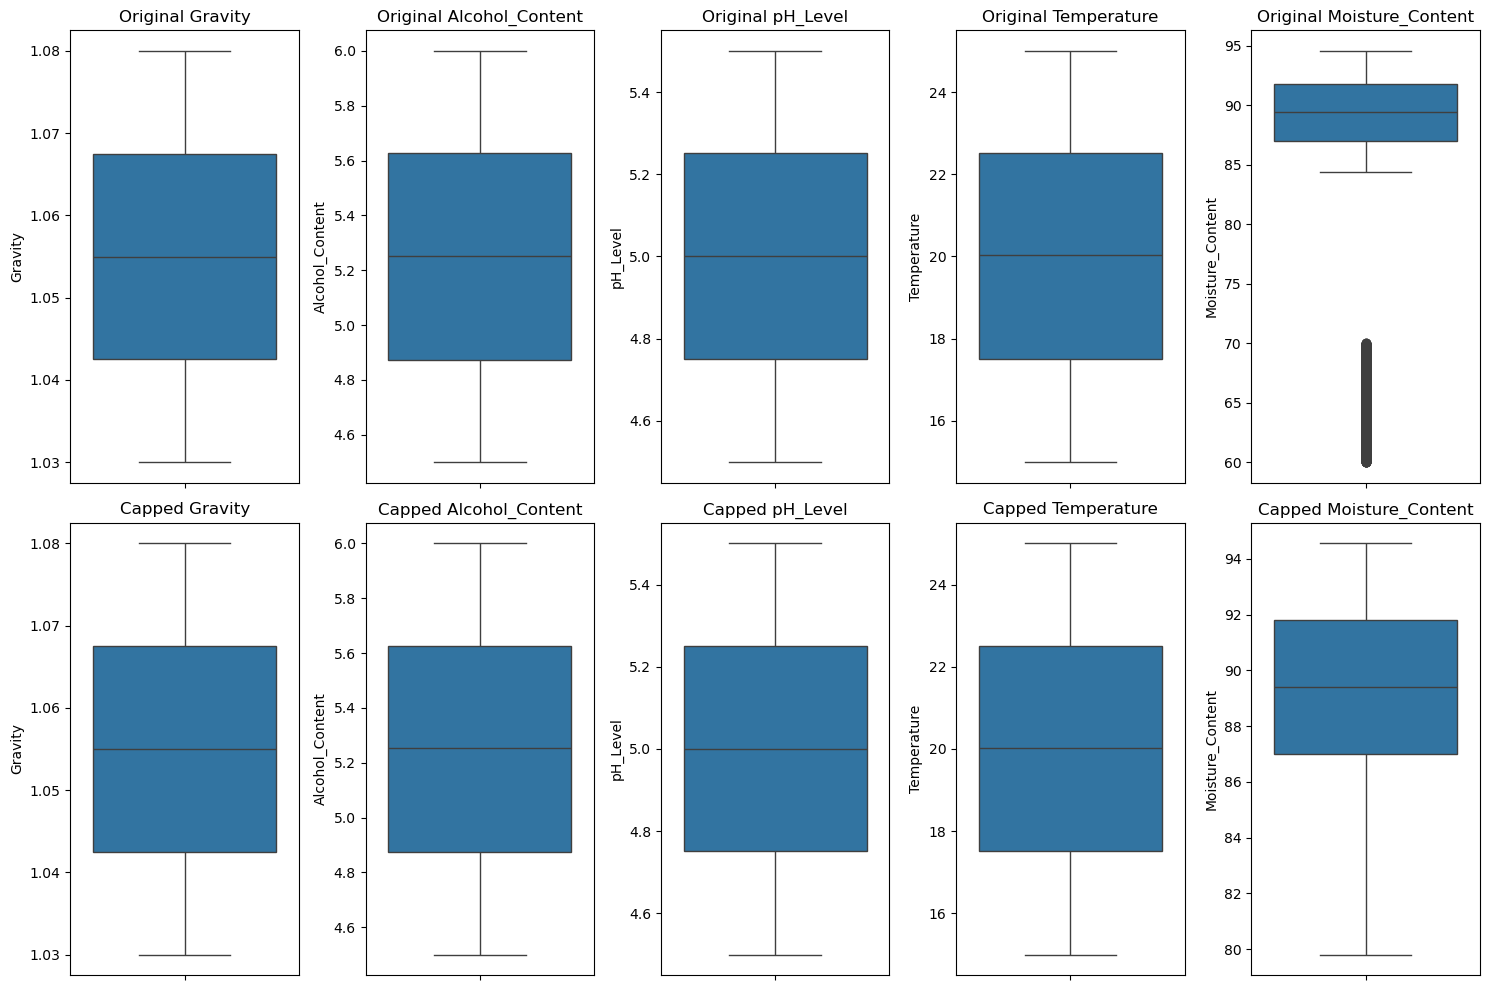


Descriptive statistics after outlier capping:
             Gravity  Alcohol_Content       pH_Level    Temperature  \
count  100000.000000    100000.000000  100000.000000  100000.000000   
mean        1.054983         5.251379       5.000560      20.019249   
std         0.014438         0.433797       0.288597       2.886794   
min         1.030000         4.500014       4.500001      15.000089   
25%         1.042492         4.873972       4.751442      17.518969   
50%         1.054978         5.252499       5.001072      20.030475   
75%         1.067493         5.627443       5.251072      22.505320   
max         1.079997         5.999956       5.499992      24.999868   

       Moisture_Content  
count     100000.000000  
mean          89.365571  
std            2.958535  
min           79.810000  
25%           87.010000  
50%           89.410000  
75%           91.810000  
max           94.550000  


In [28]:
if 'df' in locals() and df is not None and existing_thesis_cols:
    print("\n3. Outlier Detection and Treatment (IQR Capping)")
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(existing_thesis_cols):
        if pd.api.types.is_numeric_dtype(df[col]): # Ensure column is numeric
            # Original Boxplot
            plt.subplot(2, len(existing_thesis_cols), i + 1)
            sns.boxplot(y=df[col])
            plt.title(f"Original {col}")
            plt.tight_layout()

            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            print(f"\nOutlier Capping for {col}:")
            print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
            print(f"  Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")

            original_min = df[col].min()
            original_max = df[col].max()

            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

            print(f"  Values below {lower_bound:.2f} capped. Original min: {original_min:.2f}, New min: {df[col].min():.2f}")
            print(f"  Values above {upper_bound:.2f} capped. Original max: {original_max:.2f}, New max: {df[col].max():.2f}")

            # Boxplot after Capping
            plt.subplot(2, len(existing_thesis_cols), i + 1 + len(existing_thesis_cols))
            sns.boxplot(y=df[col])
            plt.title(f"Capped {col}")
            plt.tight_layout()
    plt.show()

    print("\nDescriptive statistics after outlier capping:")
    print(df[existing_thesis_cols].describe())

**4. Feature Scaling (Normalization/Standardization)**

Some machine learning algorithms are sensitive to the scale of input features.
*   **Normalization (Min-Max Scaling):** Scales features to a fixed range, typically [0, 1]. Useful when features have different ranges.
*   **Standardization (Z-score Scaling):** Transforms features to have zero mean and unit variance. Less affected by outliers than normalization and often preferred for algorithms like SVMs and PCA.

The choice between normalization and standardization depends on the algorithm and data distribution. For this study, **Standardization** will likely be preferred, but this decision can be finalized during model selection. *This step is often performed as part of the modeling pipeline (e.g., using `sklearn.preprocessing.StandardScaler`) rather than directly on the entire dataset before splitting, to prevent data leakage from the test set into the training process.*

In [30]:
if 'df' in locals() and df is not None and existing_thesis_cols:
    print("\n4. Feature Scaling (Example: Standardization - typically done in ML pipeline)")
    # This is for demonstration; in practice, fit on training data ONLY and transform train/test.
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    # Create a new DataFrame for scaled features to keep original df intact for now
    df_scaled_features = df[existing_thesis_cols].copy()
    df_scaled_features = pd.DataFrame(scaler.fit_transform(df_scaled_features), columns=existing_thesis_cols, index=df_scaled_features.index)

    print("\nDescriptive statistics of SCALED features (example):")
    print(df_scaled_features.describe())
    # Note: For actual model training, this df_scaled_features (or a similar one derived from
    #       the training set) would be used. We might add these back to df or use separately.
    # For now, we keep df with unscaled but cleaned values.


4. Feature Scaling (Example: Standardization - typically done in ML pipeline)

Descriptive statistics of SCALED features (example):
            Gravity  Alcohol_Content      pH_Level   Temperature  \
count  1.000000e+05     1.000000e+05  1.000000e+05  1.000000e+05   
mean   1.514493e-14    -2.246026e-16  2.326956e-15  2.451372e-17   
std    1.000005e+00     1.000005e+00  1.000005e+00  1.000005e+00   
min   -1.730358e+00    -1.732074e+00 -1.734465e+00 -1.738671e+00   
25%   -8.651132e-01    -8.700141e-01 -8.632081e-01 -8.661140e-01   
50%   -3.670964e-04     2.581525e-03  1.775348e-03  3.888776e-03   
75%    8.665000e-01     8.669162e-01  8.680410e-01  8.611918e-01   
max    1.732566e+00     1.725645e+00  1.730563e+00  1.725320e+00   

       Moisture_Content  
count      1.000000e+05  
mean      -4.992238e-15  
std        1.000005e+00  
min       -3.229848e+00  
25%       -7.961989e-01  
50%        1.501737e-02  
75%        8.262337e-01  
max        1.752372e+00  


# 5. Simulate Target Variable (if not already done and needed for saved file)

In [34]:
TARGET_COLUMN = 'Fermentation_Status' # Ensure this is defined if not earlier

if TARGET_COLUMN not in df.columns:
    print(f"\nSimulating '{TARGET_COLUMN}' for the preprocessed output...")
    # Example rule: "Ready" if alcohol is high and gravity (sugar) is low
    # Make sure BRIX_COLUMN and ALCOHOL_COLUMN exist and are clean
    if BRIX_COLUMN in df.columns and ALCOHOL_COLUMN in df.columns:
        df[TARGET_COLUMN] = 0 # Default to Not Ready
        # Ensure columns are numeric for comparison
        df[ALCOHOL_COLUMN] = pd.to_numeric(df[ALCOHOL_COLUMN], errors='coerce')
        df[BRIX_COLUMN] = pd.to_numeric(df[BRIX_COLUMN], errors='coerce')
        
        # Drop rows where these key columns became NaN after coercion
        df.dropna(subset=[ALCOHOL_COLUMN, BRIX_COLUMN], inplace=True)
        
        df.loc[(df[ALCOHOL_COLUMN] > 5.5) & (df[BRIX_COLUMN] < 1.045), TARGET_COLUMN] = 1
        print(f"Target variable '{TARGET_COLUMN}' distribution in preprocessed data:")
        print(df[TARGET_COLUMN].value_counts(normalize=True))
        if df[TARGET_COLUMN].nunique() < 2:
            print(f"WARNING: Target variable has less than 2 unique classes after simulation. This might be an issue for modeling.")
            # Optional: Force some balance for demonstration if severely skewed, though ideally rules should be robust
            if df[TARGET_COLUMN].sum() < len(df)*0.1 or df[TARGET_COLUMN].sum() > len(df)*0.9:
                print("Adjusting target simulation for better class balance in demo for saved file.")
                split_idx = int(len(df) * 0.4) # Make ~40% class 1
                df.iloc[:split_idx, df.columns.get_loc(TARGET_COLUMN)] = 1
                df.iloc[split_idx:, df.columns.get_loc(TARGET_COLUMN)] = 0
                np.random.shuffle(df[TARGET_COLUMN].values) # Shuffle to mix
                print(f"Adjusted target variable '{TARGET_COLUMN}' distribution:")
                print(df[TARGET_COLUMN].value_counts(normalize=True))

    else:
        print(f"ERROR: Cannot simulate target variable as '{BRIX_COLUMN}' or '{ALCOHOL_COLUMN}' are missing.")
        # Handle this error appropriately, maybe by not saving or raising an exception


Simulating 'Fermentation_Status' for the preprocessed output...
Target variable 'Fermentation_Status' distribution in preprocessed data:
Fermentation_Status
0    0.89847
1    0.10153
Name: proportion, dtype: float64


# 6. Prepare and Save Preprocessed Data 

In [39]:
if TARGET_COLUMN in df.columns and all(col in df.columns for col in existing_thesis_cols):
    columns_to_save = existing_thesis_cols + [TARGET_COLUMN]
    df_preprocessed_to_save = df[columns_to_save].copy() # Use .copy() to avoid SettingWithCopyWarning on a slice

    # Define the output path for the preprocessed CSV
    PREPROCESSED_CSV_PATH = "preprocessed_brewery_data.csv"

    try:
        df_preprocessed_to_save.to_csv(PREPROCESSED_CSV_PATH, index=False)
        print(f"\nSuccessfully saved preprocessed data with {len(df_preprocessed_to_save)} rows and columns {columns_to_save} to '{PREPROCESSED_CSV_PATH}'.")
        print("\nFirst 5 rows of the saved preprocessed data:")
        print(df_preprocessed_to_save.head())
    except Exception as e:
        print(f"Error saving preprocessed data: {e}")
else:
    print("\nCould not save preprocessed data. Target column or feature columns might be missing.")
    print(f"Target column '{TARGET_COLUMN}' present: {TARGET_COLUMN in df.columns}")
    print(f"All feature columns present in existing_thesis_cols: {all(col in df.columns for col in existing_thesis_cols)}")
    print(f"Feature columns expected: {existing_thesis_cols}")


Successfully saved preprocessed data with 100000 rows and columns ['Gravity', 'Alcohol_Content', 'pH_Level', 'Temperature', 'Moisture_Content', 'Fermentation_Status'] to 'preprocessed_brewery_data.csv'.

First 5 rows of the saved preprocessed data:
    Gravity  Alcohol_Content  pH_Level  Temperature  Moisture_Content  \
0  1.039504         5.370842  5.289845    24.204251             88.21   
1  1.059819         5.096053  5.275643    18.086763             94.00   
2  1.037476         4.824737  4.778016    15.539333             91.84   
3  1.052431         5.509243  5.345261    16.418489             90.44   
4  1.054296         5.133625  4.861854    19.144908             86.05   

   Fermentation_Status  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
